# Importación modulos y datos

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

In [15]:
data = pd.read_csv("merge_20220812.csv", low_memory=False) 

In [4]:
#data = pd.read_csv("Merge_20220730.csv", low_memory=False) 

# Exploración y limpieza de datos

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lote       423 non-null    int64  
 1   Individuo  423 non-null    int64  
 2   AE         423 non-null    float64
 3   LE         423 non-null    float64
 4   AT         423 non-null    float64
 5   LT         423 non-null    float64
 6   AA         423 non-null    float64
 7   LA         423 non-null    float64
 8   NV         423 non-null    float64
 9   Morfotipo  423 non-null    object 
 10  Labio      422 non-null    float64
 11  cox1-lsu   105 non-null    object 
dtypes: float64(8), int64(2), object(2)
memory usage: 39.8+ KB


In [17]:
data = data.dropna(subset=['Labio'])

In [18]:
data.iloc[:,2:].describe()

,AE,LE,AT,LT,AA,LA,NV,Labio
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000
mean,6.241066,1.762915,13.271043,9.780782,7.696754,6.264645,5.145000,0.578199
std,0.981204,0.375886,1.943654,1.436951,1.234116,0.914315,0.297709,0.494433
min,3.200000,0.710000,8.050000,6.170000,4.790000,4.270000,4.020000,0.000000
25%,5.582500,1.500000,11.785000,8.775000,6.770000,5.602500,4.950000,0.000000
50%,6.245000,1.760000,13.220000,9.695000,7.610000,6.145000,5.175000,1.000000
75%,6.907500,2.030000,14.587500,10.830000,8.550000,6.790000,5.340000,1.000000
max,9.040000,3.130000,19.090000,14.450000,11.950000,9.720000,5.950000,1.000000


In [19]:
print(pd.value_counts(data["Morfotipo"], sort = True, normalize=True))

LU    0.860190
LB    0.132701
DU    0.007109
Name: Morfotipo, dtype: float64


In [20]:
print(pd.value_counts(data["Labio"], sort = True, normalize=True))

1.0    0.578199
0.0    0.421801
Name: Labio, dtype: float64


In [9]:
data['cox1-lsu'].value_counts()

AA    68
HG     9
BA     3
GF     3
LA     3
GC     3
CA     2
GE     2
OA     2
DA     1
IG     1
GD     1
EA     1
AB     1
JH     1
KI     1
FA     1
MG     1
Name: cox1-lsu, dtype: int64

### Creación columnas nuevas

In [21]:
#Creamos un Filtro con NV > 4.75 y presencia de labio (divide adulto de joven???)
data["Filtro_NV"] = np.where(np.logical_or(data["NV"] > 4.75, data["Labio"] == 1),True,False)

In [22]:
print(pd.value_counts(data["Filtro_NV"], sort = True, normalize=True))

True     0.912322
False    0.087678
Name: Filtro_NV, dtype: float64


In [23]:
data["Ratio_AE_LE"] = data["AE"]/data["LE"]
data["Ratio_AA_LA"] = data["AA"]/data["LA"]
data["Ratio_AT_LT"] = data["AT"]/data["LT"]

#aux copy: 'Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT','Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA'

In [24]:
data.head()

,Lote,Individuo,AE,LE,AT,LT,AA,LA,NV,Morfotipo,Labio,cox1-lsu,Filtro_NV,Ratio_AE_LE,Ratio_AA_LA,Ratio_AT_LT
0,96,1,6.11,2.22,13.95,10.39,8.19,6.99,5.30,LU,1.0,AA,True,2.752252,1.171674,1.342637
1,96,2,5.69,1.45,11.68,8.34,6.45,5.89,5.00,LU,1.0,HG,True,3.924138,1.095076,1.400480
2,96,5,6.14,1.80,13.72,10.00,8.13,6.08,5.12,LU,1.0,NaN,True,3.411111,1.337171,1.372000
3,96,6,6.54,2.18,11.66,9.21,6.66,4.93,5.47,LU,0.0,NaN,True,3.000000,1.350913,1.266015
4,99,1,6.01,1.58,12.59,9.09,6.92,6.61,5.15,LU,1.0,HG,True,3.803797,1.046899,1.385039


### Relación entre variables

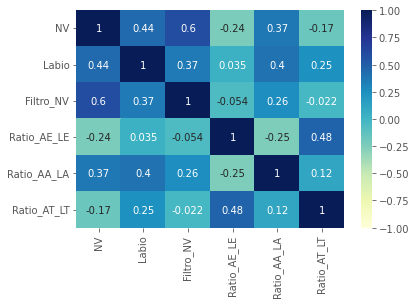

In [25]:
#variables originales del dataset
sns.heatmap(data.iloc[8:,8:].corr(), vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)

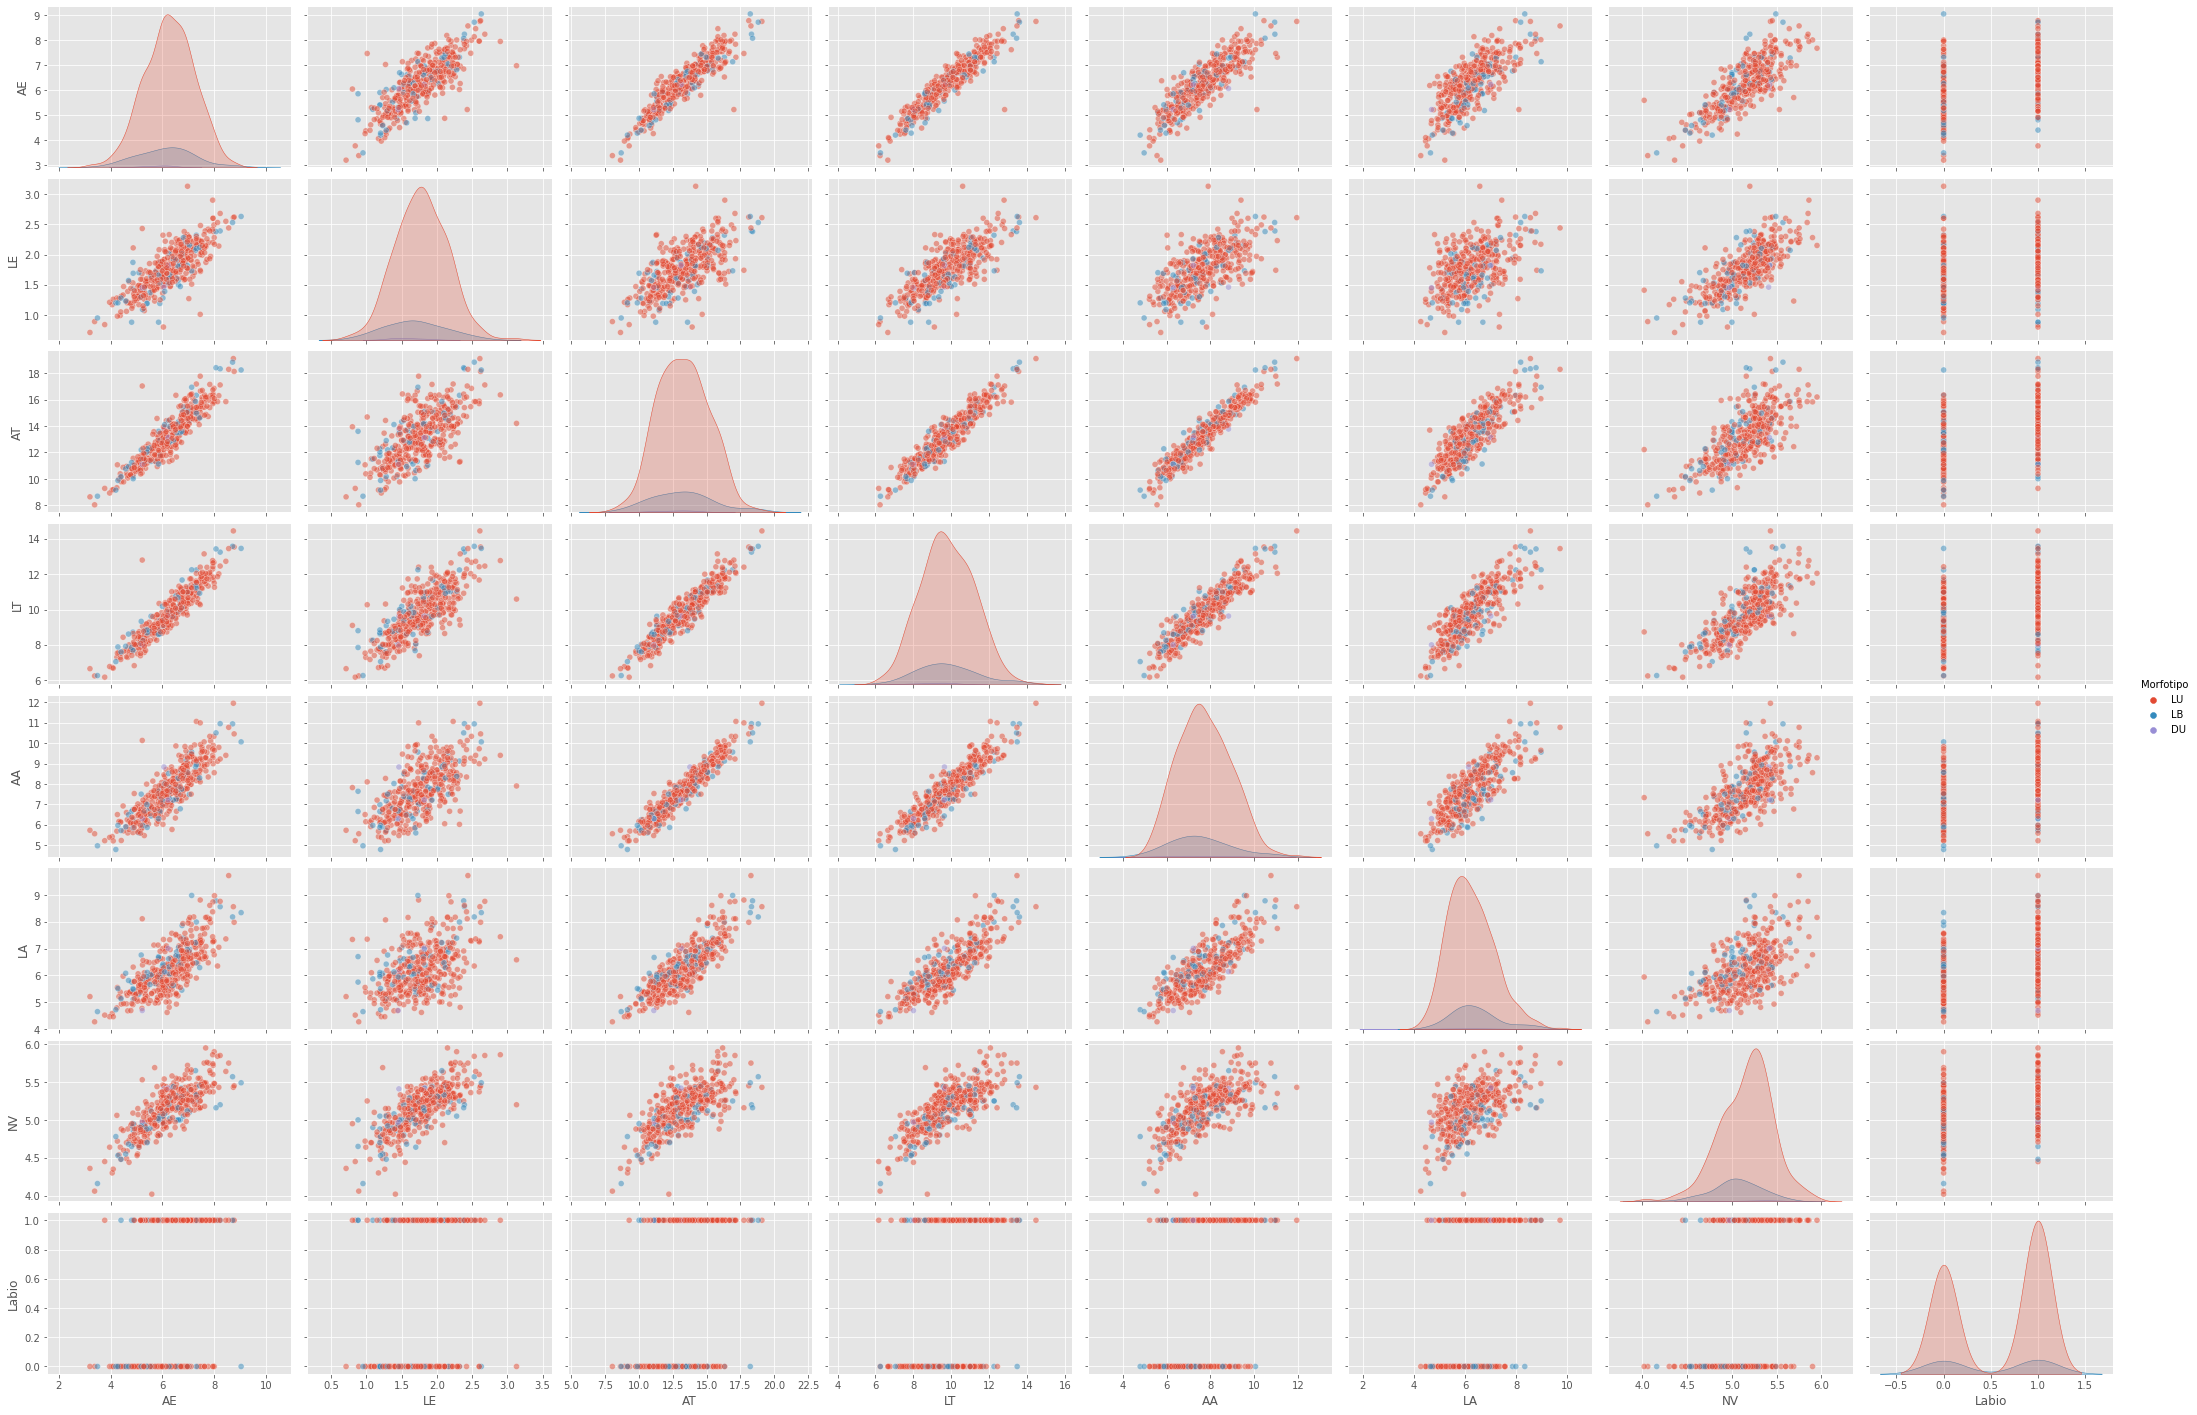

In [15]:
sns.pairplot(data=data,x_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],\
         y_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],hue='Morfotipo',plot_kws={'alpha': 0.5},aspect=1.5);

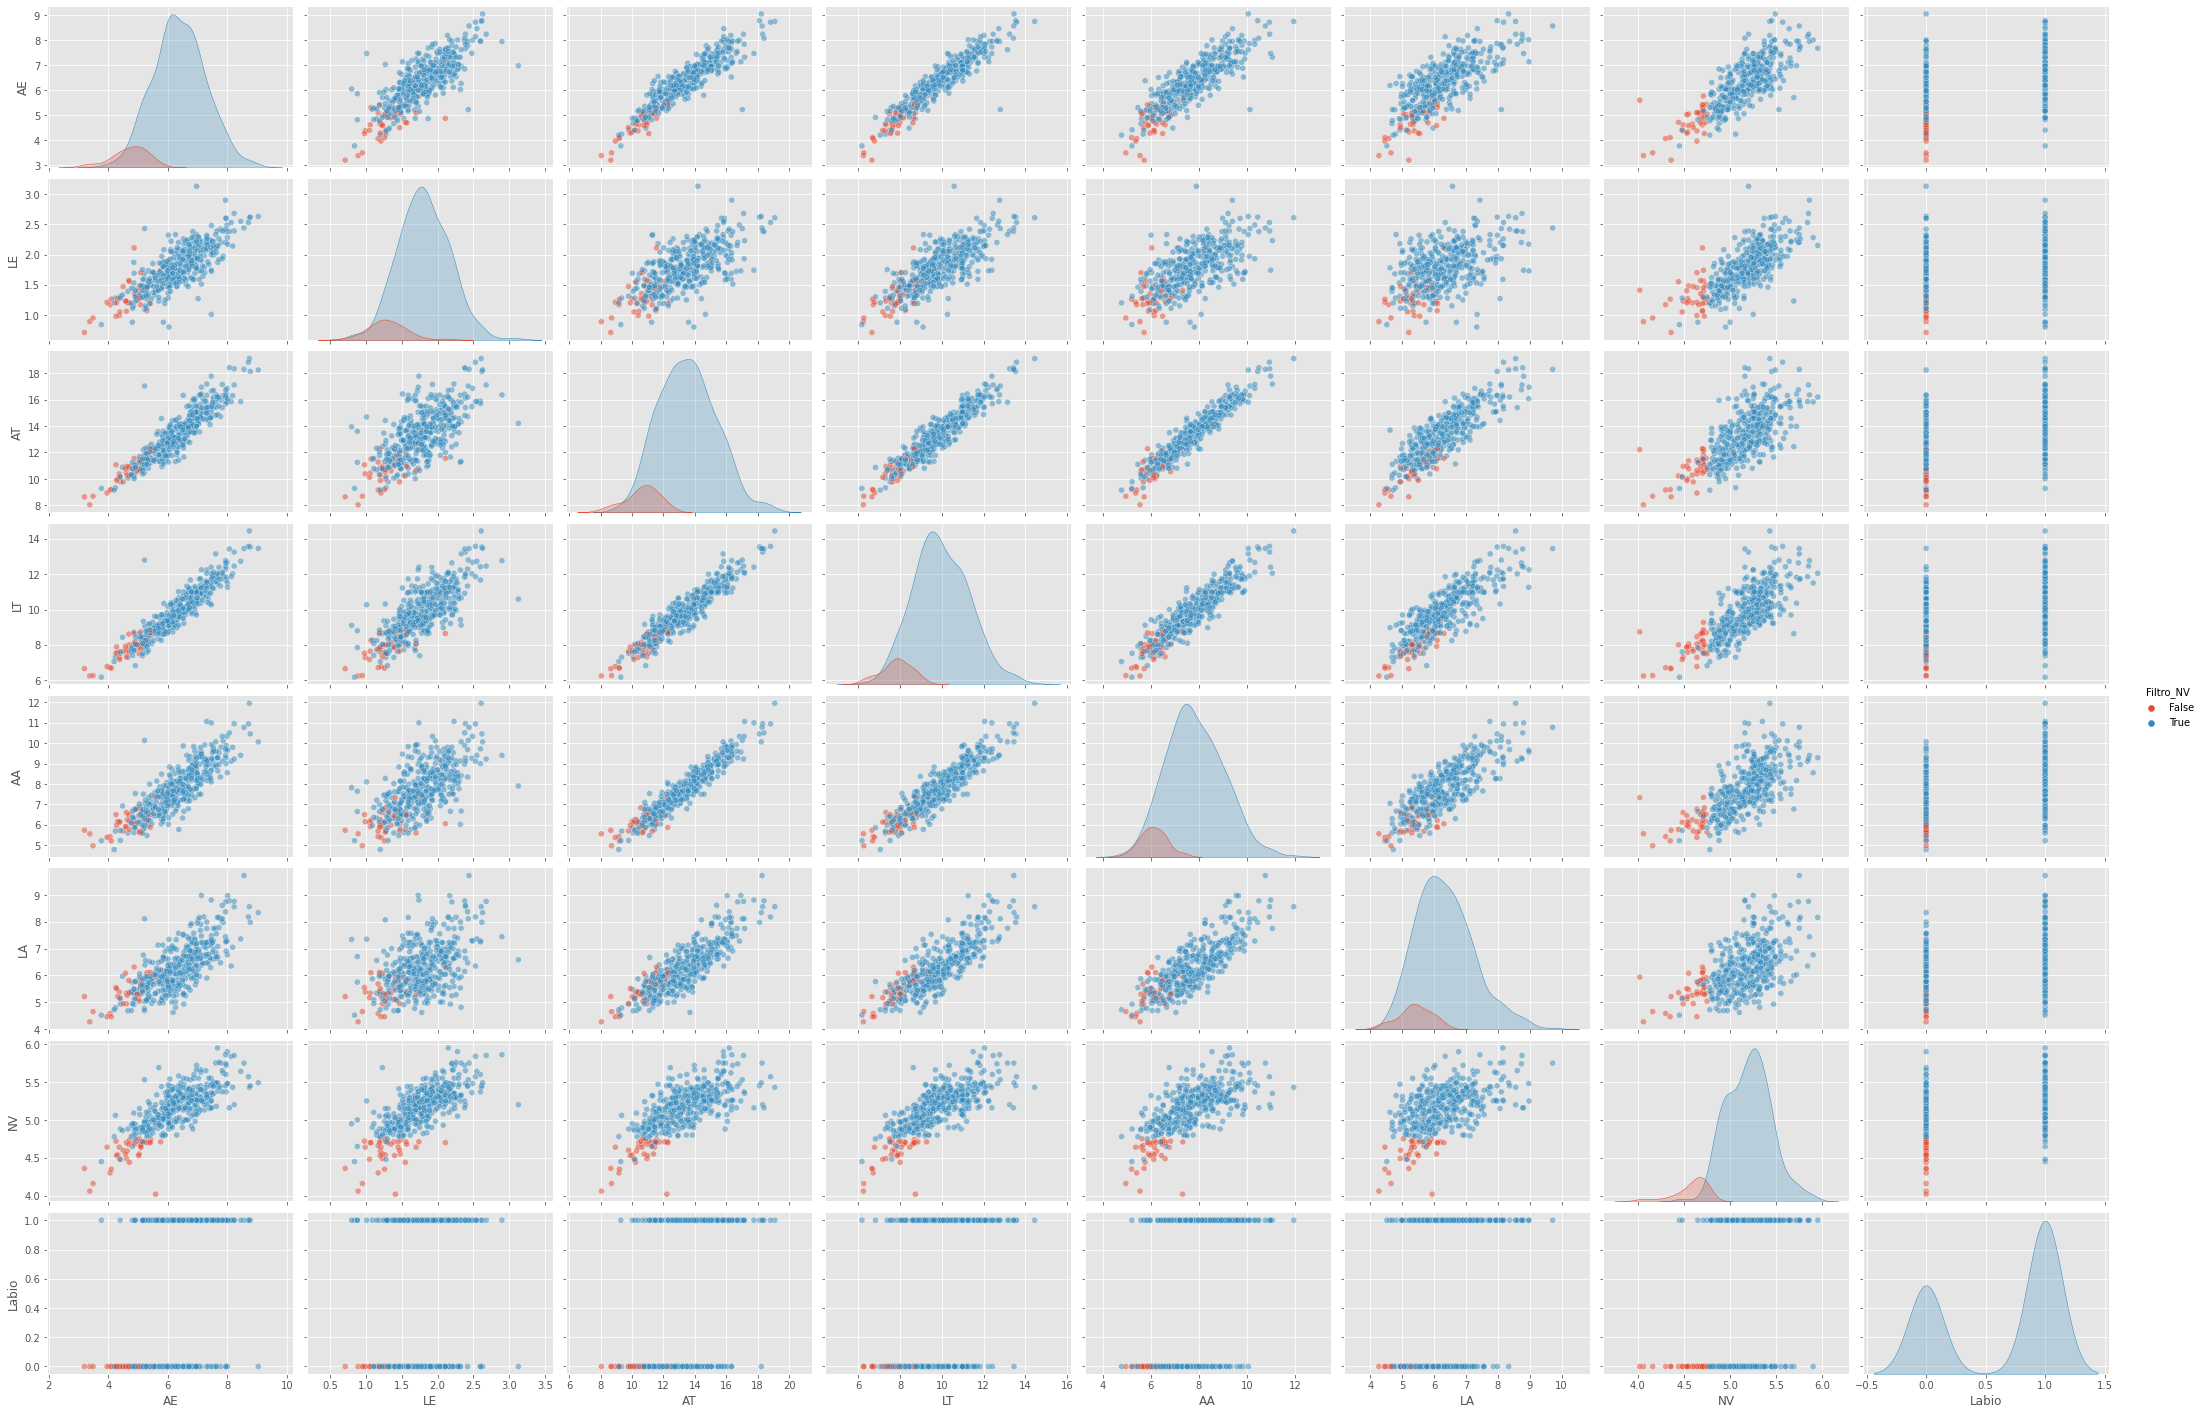

In [16]:
sns.pairplot(data=data,x_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],\
         y_vars=['AE','LE','AT','LT','AA','LA','NV','Labio'],hue='Filtro_NV',plot_kws={'alpha': 0.5},aspect=1.5);

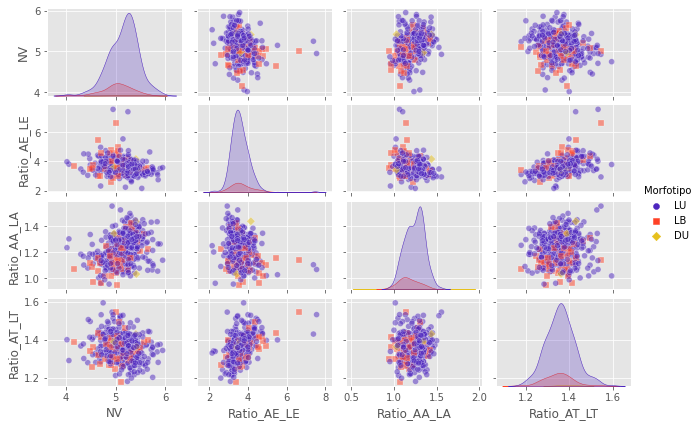

In [17]:
sns.pairplot(data=data,x_vars=['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT'],\
         y_vars=['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT'],\
             hue='Morfotipo',plot_kws={'alpha': 0.5},aspect=1.5, markers=['o','s','D'],palette='CMRmap', height=1.5);

### Distribución de las observaciones

In [ ]:
def distribution_plotter(data, label, bins="auto"):    
    plt.figure(figsize = (10,5))
    sns.set_style("white")    
    dist = sns.histplot(data, bins=bins, stat = "count", kde = False, 
                        line_kws = {'linewidth':5}, 
                        binwidth = 500)    
    dist.set_title('Distribucion ', fontsize = 16)
    plt.xticks(rotation=45, ha='right')

In [ ]:
distribution_plotter(data["Morfotipo"],data["Morfotipo"].unique())

In [26]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

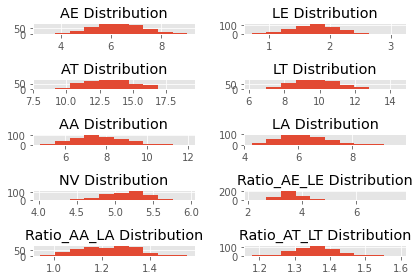

In [29]:
draw_histograms(data, data[["AE","LE","AT","LT","AA","LA","NV","Ratio_AE_LE","Ratio_AA_LA","Ratio_AT_LT"]], 5, 2)

# Modelos de clustering

## Importación modulos y dataset

In [30]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

## Prueba Kmeans

### Con las variables originales

In [31]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score,classification_report,confusion_matrix


In [32]:
x = data[['AE','LE','AT','LT','AA','LA','NV']]
y_true = data["Morfotipo"]

scaler = StandardScaler()
x_scaled=scaler.fit_transform(x);

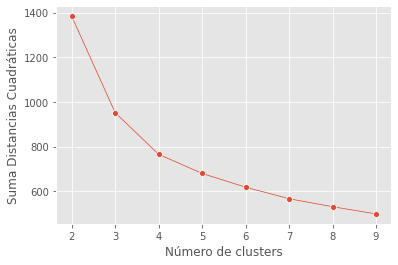

In [33]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

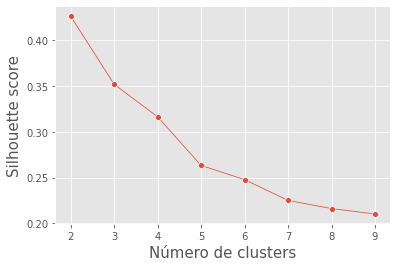

In [34]:
from sklearn.metrics import silhouette_score,silhouette_samples

sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_scaled)
    score=silhouette_score(x_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

For n_clusters = 2 The average silhouette_score is : 0.4261476532524195
For n_clusters = 3 The average silhouette_score is : 0.35183580872697623
For n_clusters = 4 The average silhouette_score is : 0.31651484102737887
For n_clusters = 5 The average silhouette_score is : 0.26325470906720644
For n_clusters = 6 The average silhouette_score is : 0.25053231946042037
For n_clusters = 7 The average silhouette_score is : 0.22686925324547152
For n_clusters = 8 The average silhouette_score is : 0.21689215726443772
For n_clusters = 9 The average silhouette_score is : 0.2115484879259307


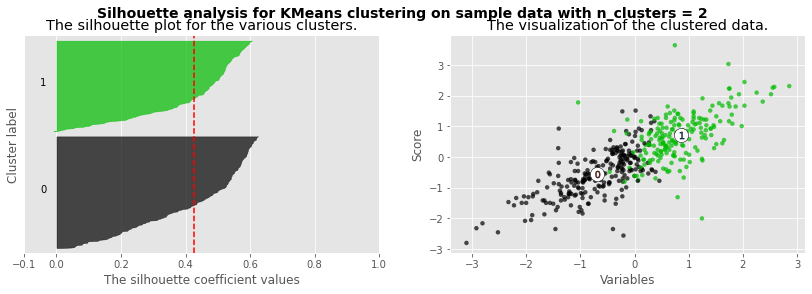

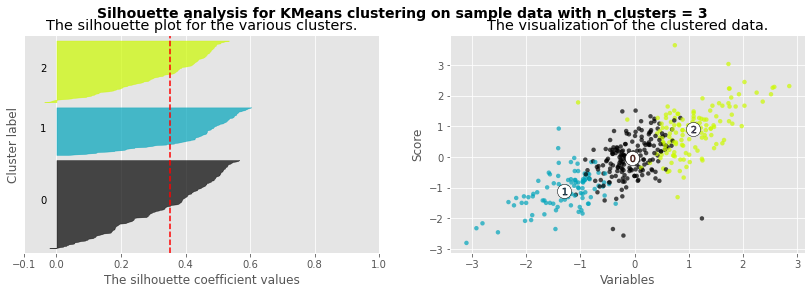

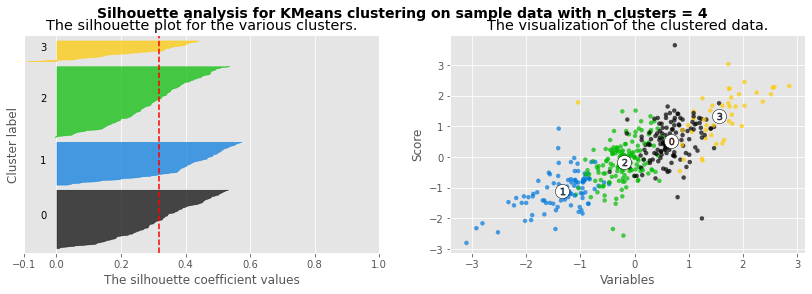

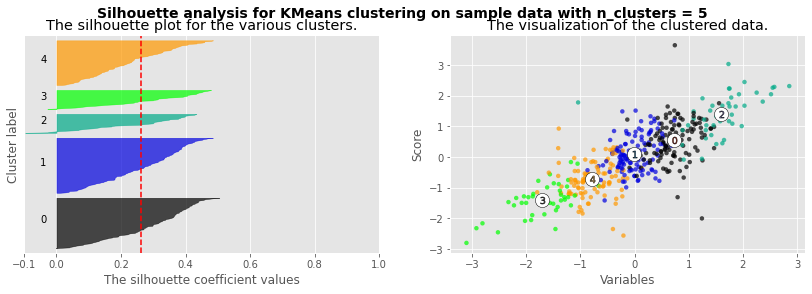

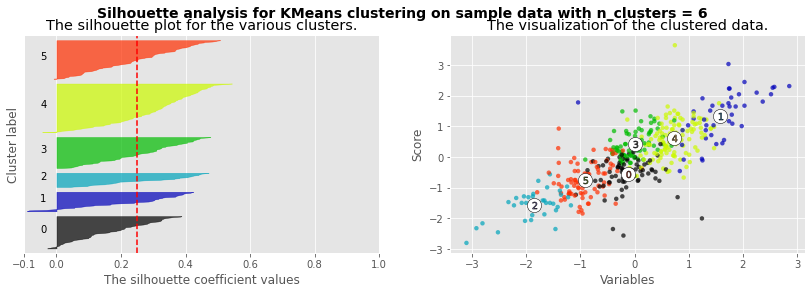

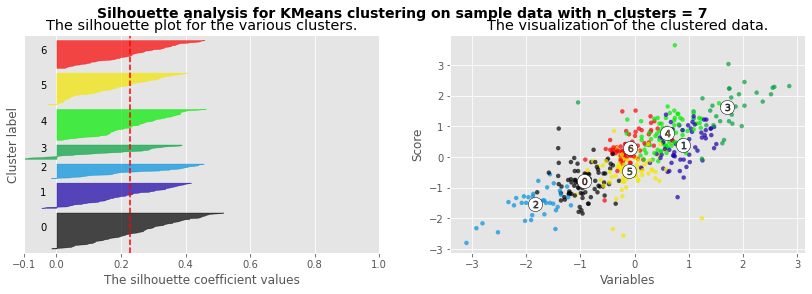

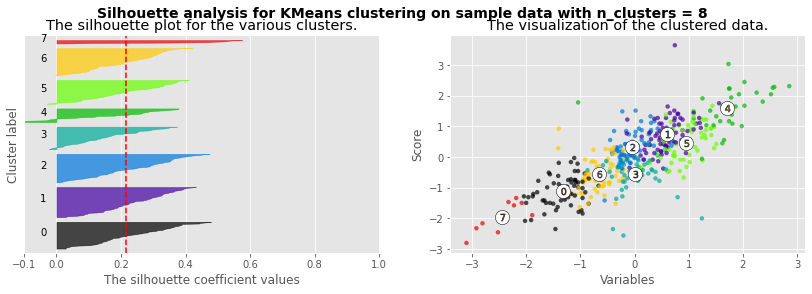

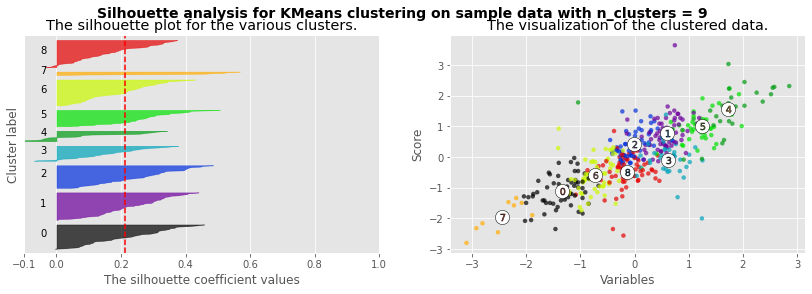

In [27]:
import matplotlib.cm as cm

for n_clusters in range(2,10):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_scaled[:, 0], x_scaled[:, 1], marker='.', s=80, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Variables")
    ax2.set_ylabel("Score")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

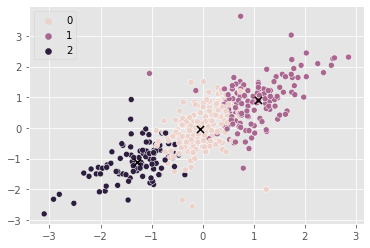

In [35]:
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_scaled[:,0],y=x_scaled[:,1],hue=labels,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

Text(0.5, 1.0, 'Kmeans')

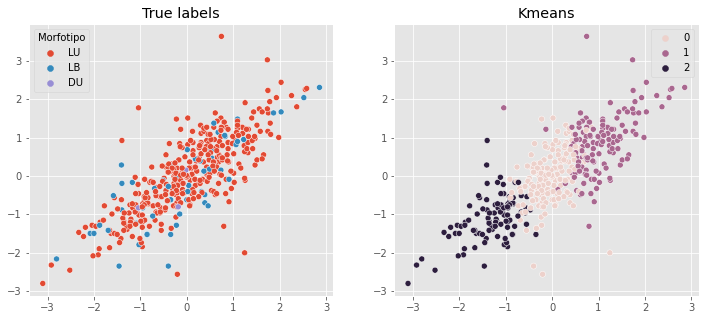

In [36]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=labels,ax=ax[1])
ax[1].set_title('Kmeans')

In [38]:
#sns.heatmap(confusion_matrix(y_true,labels),annot=True,cmap='Blues',fmt=".0f");

#print(classification_report(y_true,labels))

### Con todas las variables (menos Labio y Filtro_NV)

In [39]:
x_R = data[['AE','LE','AT','LT','AA','LA','NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
#x_R = data[['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
y_true = data["Morfotipo"]

scaler = StandardScaler()
x_R_scaled=scaler.fit_transform(x_R);

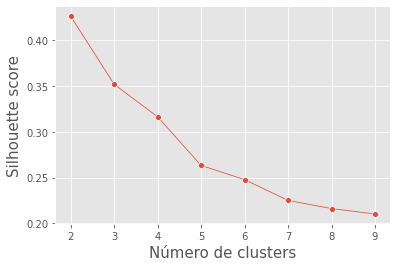

In [40]:
from sklearn.metrics import silhouette_score,silhouette_samples

sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_scaled)
    score=silhouette_score(x_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

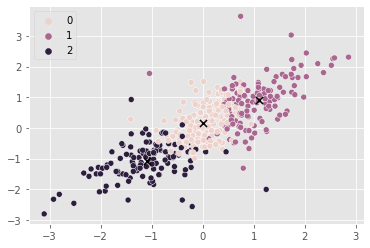

In [ ]:
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_R_scaled)

labels_R = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids_R = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_R_scaled[:,0],y=x_R_scaled[:,1],hue=labels_R,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids_R[:,0],centroids_R[:,1],marker='x',s=50,color='k');

Text(0.5, 1.0, 'Kmeans_R')

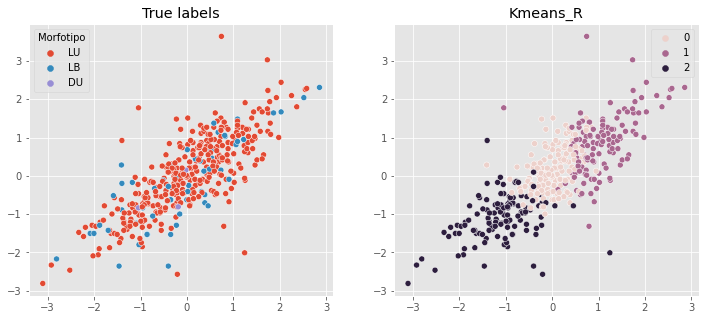

In [ ]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=labels_R,ax=ax[1])
ax[1].set_title('Kmeans_R')

## DBSCAN

In [29]:
from scipy.spatial.distance import pdist,squareform

In [30]:
minPts=20;
k=minPts-1;

D=squareform(pdist(x_R_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([1,3],0,400,linestyles='dashed');

NameError: ignored

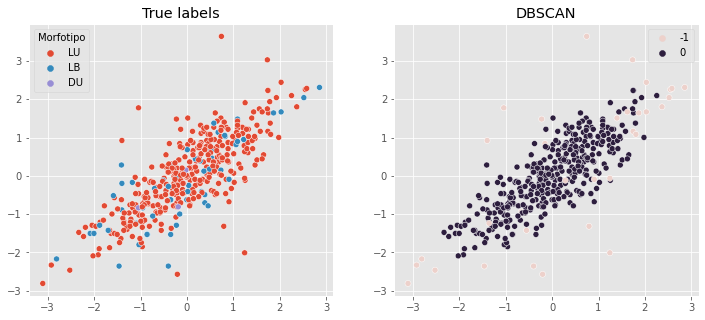

In [ ]:
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x_R_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0])
ax[0].set_title('True labels')
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=labels_db,ax=ax[1])
ax[1].set_title('DBSCAN');

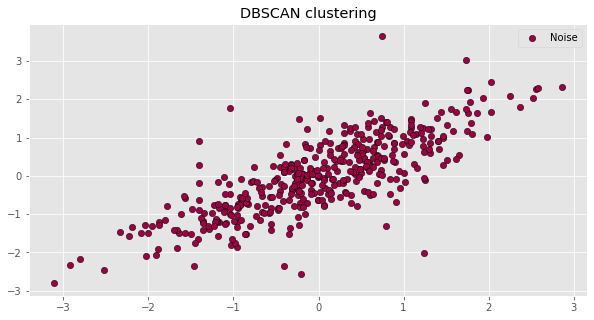

In [ ]:
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x_R_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x_R_scaled[labels==l,0], x_R_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x_R_scaled[labels==l,0], x_R_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');
    

# Modelos reducción dimensionalidad

## Prueba PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
std_sclr = StandardScaler()

X = data[['AE','LE','AT','LT','AA','LA','NV','Filtro_NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]

data_std = pd.DataFrame(std_sclr.fit_transform(X))

In [ ]:
model = PCA()

In [ ]:
model_pca = model.fit(data_std)

### Bastón quebrado

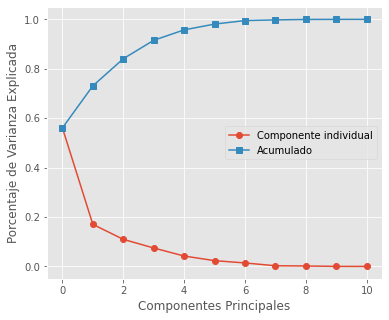

In [ ]:
plt.figure(figsize=(6,5))

plt.plot(model_pca.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

In [ ]:
#tabla de como aporta cada feature al componente
pca_df = pd.DataFrame(model_pca.components_, index =['AE','LE','AT','LT','AA','LA','NV','Filtro_NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT'], \
                      columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11'])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
AE,-0.385196,-0.336787,-0.380209,-0.391236,-0.374023,-0.316908,-0.343305,-0.219422,0.087867,-0.158008,0.039473
LE,0.055505,-0.339816,0.203375,0.033743,0.157688,0.286490,-0.111299,-0.019518,0.641212,-0.174682,0.526846
AT,-0.028081,-0.029727,0.002942,-0.142233,0.069949,-0.392467,0.066950,0.231466,0.000016,0.745005,0.453953
LT,0.010515,0.125913,0.146657,0.093444,0.201277,0.061614,-0.279727,-0.844000,-0.205499,0.226886,0.158734
AA,-0.048920,0.267176,0.058855,-0.141663,-0.147491,0.104483,-0.023611,0.156748,-0.516839,-0.392698,0.650814
LA,0.216363,0.106102,-0.081677,-0.110811,-0.283536,-0.211130,0.751506,-0.396677,0.205152,-0.121457,0.138048
NV,-0.600149,-0.369885,-0.057127,-0.065950,0.325709,0.318970,0.469091,-0.057842,-0.244634,0.065683,-0.003539
Filtro_NV,0.075397,0.448297,-0.520967,-0.493846,0.286490,0.372688,-0.038550,0.005959,0.211837,0.103198,-0.005995
Ratio_AE_LE,-0.657285,0.575747,0.181954,0.237216,-0.100363,-0.109561,0.000980,0.014945,0.352728,-0.016777,0.010689
Ratio_AA_LA,-0.013271,-0.033237,0.057523,0.025888,-0.699516,0.592652,-0.012392,-0.005696,-0.013183,0.391964,-0.013632


### Proyección

In [ ]:
#nuevo dataset con cada participación de feature
nuevo_data_pca = pd.DataFrame(model_pca.fit_transform(data_std), index =X.index,\
                              columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11'])

In [ ]:
nuevo_data_pca.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-1.374039,-1.164808,-0.764179,0.136727,1.219303,-0.285602,0.549390,0.146843,0.276357,-0.004147,-0.014486
1,2.075323,0.734797,-0.286069,-0.964863,0.652448,0.201121,-0.167749,0.078629,-0.119040,-0.053042,0.005864
2,-0.420420,-0.281178,0.941355,0.202902,-0.041026,-0.454458,0.148028,-0.113871,0.048404,0.017407,-0.001965
3,-0.007408,-2.875911,0.822267,-0.593088,-0.464654,0.986103,-0.413700,0.200776,0.011107,0.055449,-0.028917
4,0.921540,0.786109,-1.050249,-0.903735,0.824805,0.290374,0.086872,0.050427,-0.122942,0.006322,-0.005423
5,1.202628,0.773657,-0.621601,-1.007816,1.083345,0.750208,-0.200887,0.035790,-0.163048,-0.044765,-0.002276
6,-0.132507,-0.696787,-0.967707,-0.525699,1.206064,0.394996,-0.250019,0.106184,-0.022613,-0.022781,-0.020163
7,-1.327517,-1.202962,0.620982,0.198101,-0.511588,-0.189086,-0.401332,0.149278,-0.041570,0.001465,0.011422
8,0.456677,-0.988316,-0.996595,-0.982367,0.467335,0.787538,-0.564459,-0.243627,-0.013557,-0.042915,-0.017686
9,0.244447,-0.472988,1.067362,-0.219473,-0.079359,0.139021,0.171432,0.073728,-0.077835,0.009893,-0.002781


In [ ]:
nuevo_data_pca.shape

(423, 11)

### Pesos (loadings)

In [ ]:
# me quedo con los primeros 5 componentes
pca_loadings = pd.DataFrame(model_pca.components_.T, index=X.columns).iloc[:,:4]
pca_loadings.rename(columns = {0 : 'CP1', 1 : 'CP2', 2 : 'CP3', 3 : 'CP4'}, inplace = True)
pca_loadings

,CP1,CP2,CP3,CP4
AE,-0.385196,0.055505,-0.028081,0.010515
LE,-0.336787,-0.339816,-0.029727,0.125913
AT,-0.380209,0.203375,0.002942,0.146657
LT,-0.391236,0.033743,-0.142233,0.093444
AA,-0.374023,0.157688,0.069949,0.201277
LA,-0.316908,0.286490,-0.392467,0.061614
NV,-0.343305,-0.111299,0.066950,-0.279727
Filtro_NV,-0.219422,-0.019518,0.231466,-0.844000
Ratio_AE_LE,0.087867,0.641212,0.000016,-0.205499
Ratio_AA_LA,-0.158008,-0.174682,0.745005,0.226886


In [ ]:
def plot_explained_variance(components_count, X):

    model_pca = PCA(components_count).fit(X)

    explained_variance = model_pca.explained_variance_ratio_

    #print(explained_variance)

    cumulative_explained_variance = np.cumsum(explained_variance)

    #print(cumulative_explained_variance)

    plt.plot(cumulative_explained_variance)
    plt.xlabel('número de componentes')
    plt.ylabel('% de varianza explicada');

In [ ]:
plot_explained_variance(components_count = 12, X = data_std)

## Prueba TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(random_state=42)

proj_tsne = tsne.fit_transform(data_std)

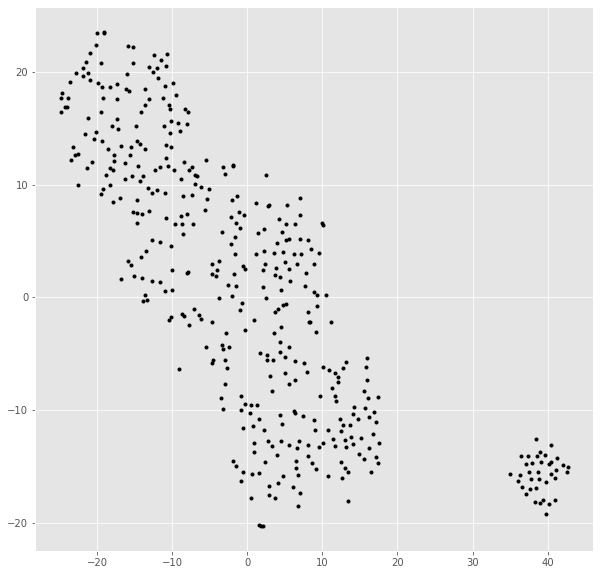

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne[:, 0]
coord_y = proj_tsne[:, 1]
ax.plot(coord_x, coord_y, '.k')    

# Modelos clasificación

## CART con oversampling

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
newX = data[['AE','LE','AT','LT','AA','LA','NV','Labio','Filtro_NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
newy = data['Morfotipo']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(newX,newy,stratify = data['Morfotipo'],random_state=0)

In [44]:
# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (316, 12)
Testeo: (106, 12)

Clases train:
LU    0.860759
LB    0.132911
DU    0.006329
Name: Morfotipo, dtype: float64

Clases test:
LU    0.858491
LB    0.132075
DU    0.009434
Name: Morfotipo, dtype: float64


### OverSampling

In [45]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
LU    272
DU    272
LB     42
Name: Morfotipo, dtype: int64

Composición del test set:
LU    91
LB    14
DU     1
Name: Morfotipo, dtype: int64


In [46]:
X_train_os2,y_train_os2=oversampler.fit_resample(X_train_os,y_train_os);

print('Composición del training set:')
print(y_train_os2.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
LU    272
LB    272
DU    272
Name: Morfotipo, dtype: int64

Composición del test set:
LU    91
LB    14
DU     1
Name: Morfotipo, dtype: int64


## CART

In [47]:
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix

In [48]:
clf_dt = DecisionTreeClassifier(max_depth = 8, random_state=42)
clf_dt = clf_dt.fit(X_train_os2,y_train_os2)

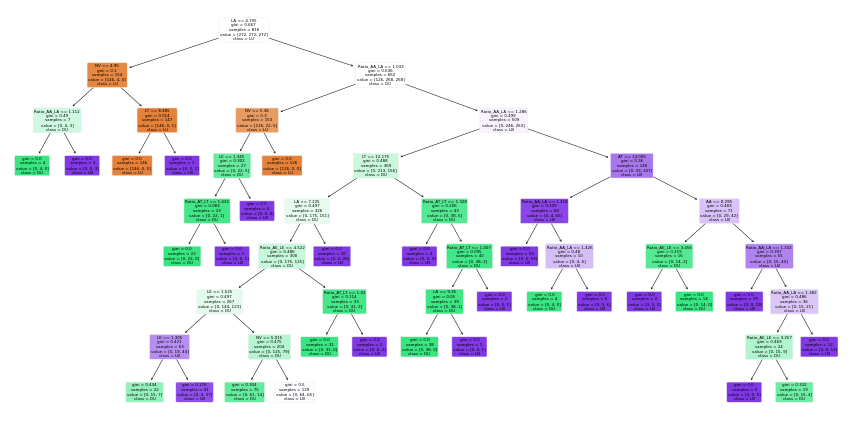

In [49]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["LU","DU", "LB"], 
          feature_names=X_train_os2.columns); 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


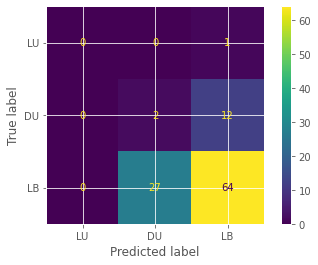

In [50]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["LU","DU","LB"])